# Intro

- 데이터가 Imbalance 일 경우, class 가 많은쪽의 분류에만 치우쳐 class 가 적은쪽의 데이터는 신경쓰지 않을 수 있다.
- 이러한 경우 학습이 잘 안되고, 비율이 큰 클래스에만 치중되는 문제가 생긴다

In [33]:
import scipy as sp
import scipy.stats 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC

In [42]:
n0 = 200; n1 = 20
rv1 = sp.stats.multivariate_normal([-1, 0], [[1, 0], [0, 1]])
rv2 = sp.stats.multivariate_normal([+1, 0], [[1, 0], [0, 1]])
X0 = rv1.rvs(n0, random_state=0)
X1 = rv2.rvs(n1, random_state=0)
X_imb = np.vstack([X0, X1])
y_imb = np.hstack([np.zeros(n0), np.ones(n1)])

x1min = -4; x1max = 4
x2min = -2; x2max = 2
xx1 = np.linspace(x1min, x1max, 1000)
xx2 = np.linspace(x2min, x2max, 1000)
X1, X2 = np.meshgrid(xx1, xx2)

def classification_result2(X, y, title=""):
    plt.contour(X1, X2, rv1.pdf(np.dstack([X1, X2])), levels=[0.05], linestyles="dashed")
    plt.contour(X1, X2, rv2.pdf(np.dstack([X1, X2])), levels=[0.05], linestyles="dashed")
    model = SVC(kernel="linear", C=1e4, random_state=0).fit(X, y)
    Y = np.reshape(model.predict(np.array([X1.ravel(), X2.ravel()]).T), X1.shape)
    plt.scatter(X[y == 0, 0], X[y == 0, 1], marker='x', label="0 클래스")
    plt.scatter(X[y == 1, 0], X[y == 1, 1], marker='o', label="1 클래스")
    plt.contour(X1, X2, Y, colors='k', levels=[0.5])
    y_pred = model.predict(X)
    plt.xlim(-4, 4)
    plt.ylim(-3, 3)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.title(title)
    return model

- 현재 데이터는 아래와 같이 Imbananced 하게 데이터가 형성되어 있는 모습
- 대부분을 비율이 높은 데이터로 분류하더라도, 큰 accuracy 가 나오기 떄문에 학습이 잘 안될 수 있다.

SVC(C=10000.0, kernel='linear', random_state=0)

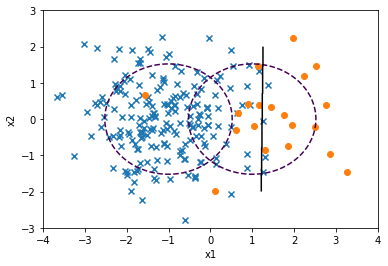

In [44]:
classification_result2(X_imb, y_imb)

# Under sampling

- Under sampling 은 빈도가 높은 데이터의 일부를 삭제함으로서 비율을 맞추어진다.

## Random

- 큰 비율을 가지는 데이터를 무작위로 삭제한다.


In [51]:
from imblearn.under_sampling import (RandomUnderSampler, 
                                     ClusterCentroids,
                                     TomekLinks,
                                     CondensedNearestNeighbour,
                                     OneSidedSelection,
                                     EditedNearestNeighbours,
                                     NeighbourhoodCleaningRule,
                                     NearMiss)

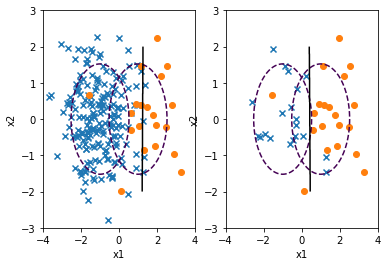

In [46]:
X_samp, y_samp = RandomUnderSampler(random_state=0).fit_sample(X_imb, y_imb)

plt.subplot(121)
classification_result2(X_imb, y_imb)
plt.subplot(122)
model_samp = classification_result2(X_samp, y_samp)


## Tomeklink

- 토멕링크(Tomek’s link)란 서로 다른 클래스에 속하는 한 쌍의 데이터 (x_1,x_2)로 서로에게 더 가까운 다른 데이터가 존재하지 않는 것이다. 
- 즉 클래스가 다른 두 데이터가 아주 가까이 붙어있으면 토멕링크가 된다. 
- 토멕링크 방법은 이러한 토멕링크를 찾은 다음 그 중에서 다수 클래스에 속하는 데이터를 제외하는 방법이다.
- 이 방법은 경계선을 다수 클래스쪽으로 밀어붙이는 효과가 있다.
- Tomek link는 분포가 높은 클래스의 중심분포는 어느정도 유지하면서 경계선을 조정하기 때문에 무작위로 삭제하는 샘플링보다 정보의 유실을 크게 방지할 수 있다.
- 하지만 토멕링크로 묶이는 값이 한정적이기 때문에 큰 언더 샘플링의 효과를 얻을 수 없다.




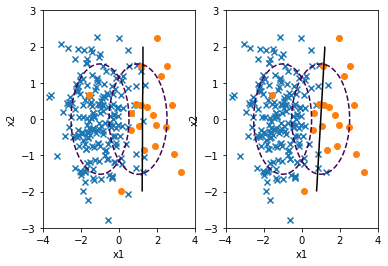

In [47]:
X_samp, y_samp = TomekLinks().fit_sample(X_imb, y_imb)

plt.subplot(121)
classification_result2(X_imb, y_imb)
plt.subplot(122)
model_samp = classification_result2(X_samp, y_samp)


## CNN

CNN 방법은 최근접인 클래스 분포 데이터를 삭제하면서 샘플링하는 방법.

 
1. 분포가 작은 클래스르 S분포로 둡니다.

2. 분포가 큰 클래스를 랜덤으로 하나 선택한 뒤 그 데이터 위치에서 가장 가까운 데이터를 선택했을 때 S 분포에 포함 되어 있지 않은 데이터라면 제거합니다.

3. 가장 가까운 값이 S분포가 나올 때까지 2번을 반복합니다.

- 이 방법을 사용하면 기존에 선택된 데이터와 가까이 있으면서 같은 클래스인 데이터는 선택되지 않기 때문에 다수 데이터의 경우 선택되는 비율이 적어진다.




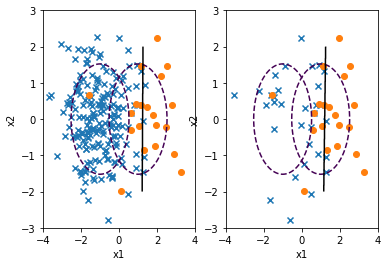

In [48]:
X_samp, y_samp = CondensedNearestNeighbour(random_state=0).fit_sample(X_imb, y_imb)

plt.subplot(121)
classification_result2(X_imb, y_imb)
plt.subplot(122)
model_samp = classification_result2(X_samp, y_samp)


## Oneside

- Tomek link 방법론과 CNN방법론을 합쳐서 만든 One sided Selection 방법론
- 토멕링크로 먼저 데이터를 제거한 후 분포가 큰 클래스 내부에서 CNN방법으로 데이터를 데이터를 제거하는 과정을 거치는 방법

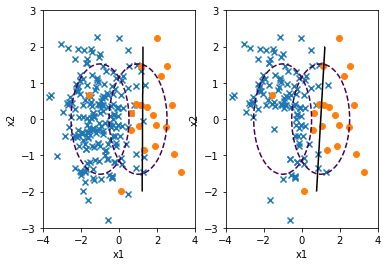

In [52]:
X_samp, y_samp = OneSidedSelection(random_state=0).fit_sample(X_imb, y_imb)

plt.subplot(121)
classification_result2(X_imb, y_imb)
plt.subplot(122)
model_samp = classification_result2(X_samp, y_samp)

## (ENN)Edited Nearest

- 다수 클래스 데이터 중 가장 가까운 k(n_neighbors)개의 데이터가 모두(kind_sel="all") 또는 다수(kind_sel="mode") 다수 클래스가 아니면 삭제하는 방법이다.
- 소수 클래스 주변의 다수 클래스 데이터는 사라진다.

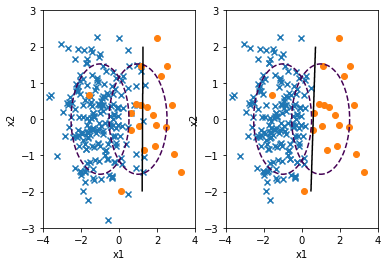

In [49]:
X_samp, y_samp = EditedNearestNeighbours(kind_sel="all", n_neighbors=5).fit_sample(X_imb, y_imb)

plt.subplot(121)
classification_result2(X_imb, y_imb)
plt.subplot(122)
model_samp = classification_result2(X_samp, y_samp)

## CNN + ENN

CNN(Condensed Nearest Neighbour) 방법과 ENN(Edited Nearest Neighbours) 방법을 섞은 것

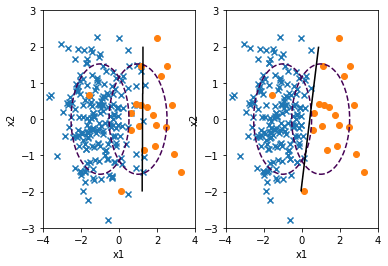

In [54]:
X_samp, y_samp = NeighbourhoodCleaningRule(kind_sel="all", n_neighbors=5).fit_sample(X_imb, y_imb)

plt.subplot(121)
classification_result2(X_imb, y_imb)
plt.subplot(122)
model_samp = classification_result2(X_samp, y_samp)


# Over Sampling

- Over sampling 은, 데이터셋에서 적은 비율에 속하는 클래스의 데이터를 늘리는 방법 
- 데이터 손실을 줄일 수 있으나 과적합이 우려된다.

In [55]:
from imblearn.over_sampling import (RandomOverSampler,
                                    ADASYN,
                                    SMOTE
                                    )

## Random

- Random Over Sampling은 소수 클래스의 데이터를 반복해서 넣는 것(replacement)이다. 가중치를 증가시키는 것과 비슷하다
- 반복해서 넣는것이기 때문에 데이터가 변하지 않은것 같지만, 겹쳐있는 것이다

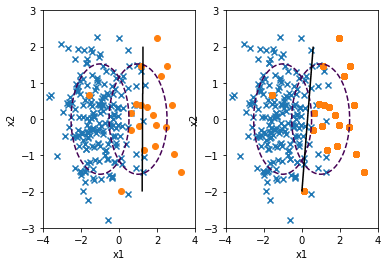

In [61]:
from imblearn.over_sampling import RandomOverSampler
X_samp, y_samp = RandomOverSampler(random_state=0).fit_sample(X_imb, y_imb)

plt.subplot(121)
classification_result2(X_imb, y_imb)
plt.subplot(122)
model_samp = classification_result2(X_samp, y_samp)


## ADASYN

-  분포가 작은 클래스 데이터와 그 데이터와 가장 가까운 무작위의 K개의 데이터 사이에 가상의 직선을 그려서 직선상에 존재하는 가상의 분포가 작은 클래스 데이터를 생성하는 것

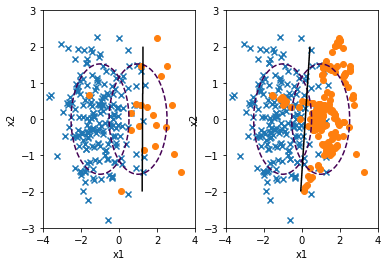

In [69]:
from imblearn.over_sampling import ADASYN
                                    
X_samp, y_samp = ADASYN(random_state=0).fit_sample(X_imb, y_imb)

plt.subplot(121)
classification_result2(X_imb, y_imb)
plt.subplot(122)
model_samp = classification_result2(X_samp, y_samp)


## SMOTE

- SMOTE(Synthetic Minority Over-sampling Technique) 방법도 ADASYN 방법처럼 데이터를 생성하지만 생성된 데이터를 무조건 소수 클래스라고 하지 않고 분류 모형에 따라 분류한다.

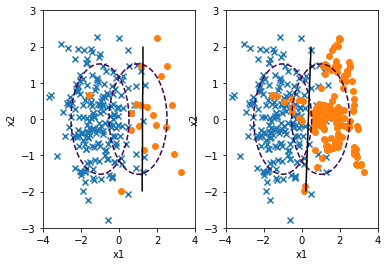

In [25]:
X_samp, y_samp = SMOTE(random_state=4).fit_sample(X_imb, y_imb)

plt.subplot(121)
classification_result2(X_imb, y_imb)
plt.subplot(122)
model_samp = classification_result2(X_samp, y_samp)


# Combine

- 복합적으로 Over sampling 과 Under sampling 두개를 둘다 하는것이다.

In [3]:
from imblearn.combine import (SMOTEENN,
                              SMOTETomek)

## SMOTE+ENN

- SMOTE와 ENN방법론을 결합한 방식입니다



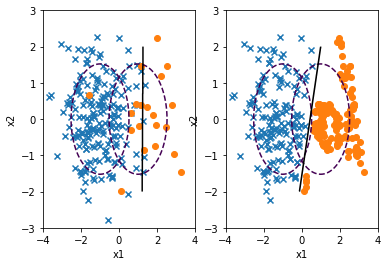

In [60]:
X_samp, y_samp = SMOTEENN(random_state=0).fit_sample(X_imb, y_imb)

plt.subplot(121)
classification_result2(X_imb, y_imb)
plt.subplot(122)
model_samp = classification_result2(X_samp, y_samp)


## SMOTE+TOMEK

SMOTE+Tomek 방법은 SMOTE(Synthetic Minority Over-sampling Technique) 방법과 토멕링크 방법을 섞은 것.

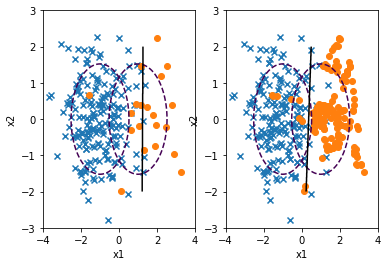

In [29]:
X_samp, y_samp = SMOTETomek(random_state=4).fit_sample(X_imb, y_imb)

plt.subplot(121)
classification_result2(X_imb, y_imb)
plt.subplot(122)
model_samp = classification_result2(X_samp, y_samp)


# Parameter

## Ratio(sampling_strategy)

- 매우 imbalanced 한 데이터의 경우, 비율이 똑같아 지려면 원래 데이터의 10~100배까지 늘려야 할 때가 있다.
- 이러한 경우를 예방하려고 한다면 Ratio 를 조절하면 된다.
- sampling strategy = 0.3 으로 놓는다면, 최대 class 를 가진 데이터의 30%까지 upsampling 하라는 의미이다.

- 먼저 classification 에서 X,y set 으로 나누었다고 하자. 그러면
- temp = y.value_counts()
- dic = dict(zip(temp.index,temp.values))
- SMOTETomek(random_state=4,sampling_strategy=dic).fit_sample(X, y) 을 통해서 내식대로 조절 가능
- 이 temp 의 counts 비율을 조절함으로서, Ratio 를 임의로 잘 조절할 수 있다.

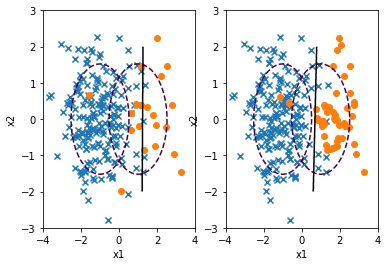

In [72]:
X_samp, y_samp = SMOTETomek(random_state=4,sampling_strategy=0.3).fit_sample(X_imb, y_imb)

plt.subplot(121)
classification_result2(X_imb, y_imb)
plt.subplot(122)
model_samp = classification_result2(X_samp, y_samp)


# Reference

- https://shinminyong.tistory.com/m/34?category=923792
- https://datascienceschool.net/03%20machine%20learning/14.02%20%EB%B9%84%EB%8C%80%EC%B9%AD%20%EB%8D%B0%EC%9D%B4%ED%84%B0%20%EB%AC%B8%EC%A0%9C.html